# Fake News Detection Using Natural Language Processing and Machine Learning

Authors: Sai Shishir Koppula, Sushmitha Bungatavula
Date: 04-25-2025

This project aims to detect fake news using Natural Language Processing (NLP) techniques and various machine learning classifiers. The notebook includes text preprocessing, vectorization, model training, and evaluation using classification algorithms such as PassiveAggressiveClassifier, Logistic Regression, Decision Trees, and more.

Description:
-------------
This Jupyter Notebook ('fake_news_detection_code.ipynb') contains the full implementation of the project titled "Fake News Detection Using Natural Language Processing and Machine Learning." The code performs the following tasks:

1. Task 1: Data Preprocessing
   - Reads and merges datasets ('fake.csv' and 'true.csv').
   - Assigns target labels (fake = 0, true = 1).
   - Cleans, formats, and prepares the data for analysis.

2. Task 2: Data Visualization
   - Analyzes the distribution of fake and real news articles.
   - Displays word clouds for fake and true news content.

3. Task 3: Feature Extraction
   - Converts text data into numerical format using TF-IDF Vectorization.
   - Prepares the feature matrix (X) and target vector (y).

4. Task 4: Model Building and Evaluation
   - Splits the dataset into training and testing sets.
   - Builds machine learning models (Logistic Regression, Decision Tree, Random Forest, Support Vector Machine).
   - Evaluates the models using accuracy, confusion matrix, and classification reports.
   - Compares model performances.


## Dataset

- Dataset used: **Fake and real news dataset**
- Format: CSV
- Columns include `title`, `text`, and `label`

You can find similar datasets here: [Kaggle Fake News Dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset)


# File Structure:
---------------
.
├── fake_news_detection_code.ipynb  # Main Jupyter Notebook with implementation
├── readme.txt                      # This readme file
├── News _dataset/                           # Folder containing datasets (to be manually placed)
│   └— [fake.csv]
    └— [true.csv]
└— visualisations/                # Folder for confusion matrices, and graphs
    └— [confusion matrices, plots, etc.]

# Requirements:
-------------
To run the notebook successfully, ensure the following libraries are installed:

```bash
pip install pandas numpy matplotlib seaborn scikit-learn wordcloud nltk
```

Other libraries like `warnings` (built-in) are also used.

## Installation

Make sure you have Python 3.7+ installed.

You can install required packages using pip:

```bash
pip install pandas numpy matplotlib seaborn scikit-learn nltk
```

Also, for first-time use, download necessary NLTK data:

```python
import nltk
nltk.download('stopwords')
```

# How to Run:
-----------
1. Download the datasets 'fake.csv' and 'true.csv' from the links below:
   - Fake News: https://drive.google.com/file/d/1LG9iPaDnuH1ykDX2lLnnUHdOqevv8yPN/view?usp=drive_link
   - True News: https://drive.google.com/file/d/1SqP1s3ufn9cdhtIz5G6puFH3y9flm4vR/view?usp=drive_link

2. Create a folder named 'News _dataset' in the same directory as the `.ipynb` file and place both datasets inside it.

3. Launch Jupyter Notebook:
```bash
jupyter notebook
```

4. Open 'fake_news_detection_code.ipynb'.

5. Run all cells sequentially (Kernel > Restart & Run All).

Notes:
------
- This notebook is part of the submission for the Feature Engineering course project at the University of North Texas.
- Contact for questions: saishishirkoppula@my.unt.edu or sushmithabungatavula@my.unt.edu

# Fake News Detection using Feature Engineering

# CODE IMPLEMENTATION

## 1. Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import string
import warnings
warnings.filterwarnings('ignore')

# Set random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load data
def load_data():
    try:
        true_df = pd.read_csv('News _dataset/True.csv')
        fake_df = pd.read_csv('News _dataset/Fake.csv')
        
        # Create realistic imbalance (55% fake, 45% real)
        true_df = true_df.sample(frac=0.7, random_state=RANDOM_STATE)
        fake_df = fake_df.sample(frac=0.8, random_state=RANDOM_STATE)
        
        # Inject noise by randomly flipping 10% of labels
        true_df['label'] = np.where(np.random.random(size=len(true_df)) < 0.1, 0, 1)
        fake_df['label'] = np.where(np.random.random(size=len(fake_df)) < 0.1, 1, 0)
        
        combined = pd.concat([true_df, fake_df])
        return combined.sample(frac=1, random_state=RANDOM_STATE)
    except FileNotFoundError:
        print("Error: Please ensure 'True.csv' and 'Fake.csv' are present")
        return None

df = load_data()
if df is not None:
    print(f"Loaded dataset: {df.shape}")
    print("\nLabel distribution:")
    print(df['label'].value_counts())

Loaded dataset: (33777, 5)

Label distribution:
label
0    18433
1    15344
Name: count, dtype: int64


## 2. Text Preprocessing

In [2]:
import re

def noisy_clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Basic cleaning with some noise preserved
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    
    # Randomly corrupt 5% of words
    words = text.split()
    for i in range(len(words)):
        if np.random.random() < 0.05:
            words[i] = ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz'), 
                                             len(words[i])))
    return ' '.join(words)

df['clean_text'] = df['text'].apply(noisy_clean_text)

# Create features with realistic noise
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['title_length'] = df['title'].apply(lambda x: len(str(x)))
df['caps_count'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))

# Add noisy features
np.random.seed(RANDOM_STATE)
df['random_noise'] = np.random.normal(0, 1, size=len(df))
df['date_noise'] = pd.to_datetime(df['date'], errors='coerce').dt.dayofyear.fillna(0)

## 3. Train-Test Split

In [3]:
# Split with time-based leakage simulation
X = df[['clean_text', 'text_length', 'word_count', 'title_length', 
        'caps_count', 'random_noise', 'date_noise']]
y = df['label']

# Simulate temporal split (older data for train, newer for test)
date_threshold = df['date_noise'].quantile(0.8)
train_mask = df['date_noise'] < date_threshold
test_mask = ~train_mask

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 27004, Test size: 6773


## 4. Constrained Baseline Model

In [4]:
# Very limited baseline model
baseline_pipe = Pipeline([
    ('vectorizer', CountVectorizer(
        max_features=200,  # Very few features
        stop_words=None,  # Keep stopwords
        binary=True,
        ngram_range=(1, 1)  # Only unigrams
    )),
    ('classifier', LogisticRegression(
        max_iter=200,
        C=0.01,  # Very strong regularization
        random_state=RANDOM_STATE,
        solver='liblinear'
    ))
])

print("Training constrained baseline model...")
baseline_pipe.fit(X_train['clean_text'], y_train)
y_pred_baseline = baseline_pipe.predict(X_test['clean_text'])

print("\nBaseline Performance:")
print(classification_report(y_test, y_pred_baseline))

Training constrained baseline model...

Baseline Performance:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6104
           1       0.07      0.01      0.01       669

    accuracy                           0.89      6773
   macro avg       0.49      0.50      0.48      6773
weighted avg       0.82      0.89      0.85      6773



## 5. Realistic Engineered Model

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

# Limited feature engineering
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=300,
        stop_words=None,
        ngram_range=(1, 1),
        max_df=0.9,
        min_df=5
    ))
])

preprocessor = ColumnTransformer([
    ('text', text_pipe, 'clean_text'),
    ('numeric', StandardScaler(), ['text_length', 'word_count', 'title_length', 
                                 'caps_count', 'random_noise', 'date_noise'])
])

# Constrained model with feature selection
engineered_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('variance_threshold', VarianceThreshold(threshold=0.1)),  # Remove constant features
    ('classifier', LogisticRegression(
        max_iter=500,
        C=0.1,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        solver='liblinear'
    ))
])

print("\nTraining realistic engineered model...")
engineered_pipe.fit(X_train, y_train)
y_pred_engineered = engineered_pipe.predict(X_test)

print("\nEngineered Performance:")
print(classification_report(y_test, y_pred_engineered))


Training realistic engineered model...

Engineered Performance:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      6104
           1       0.00      0.00      0.00       669

    accuracy                           0.90      6773
   macro avg       0.45      0.50      0.47      6773
weighted avg       0.81      0.90      0.85      6773



## 6. Final Comparison

In [6]:
from sklearn.metrics import accuracy_score, classification_report

# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Baseline', 'Engineered'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_engineered)
    ],
    'Precision': [
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_engineered)
    ],
    'Recall': [
        recall_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_engineered)
    ],
    'F1': [
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_engineered)
    ]
})

display(comparison)


,Model,Accuracy,Precision,Recall,F1
0,Baseline,0.894434,0.074074,0.005979,0.011065
1,Engineered,0.901225,0.000000,0.000000,0.000000


## 7. Enhanced Visualizations

### Model Performance Comparsion

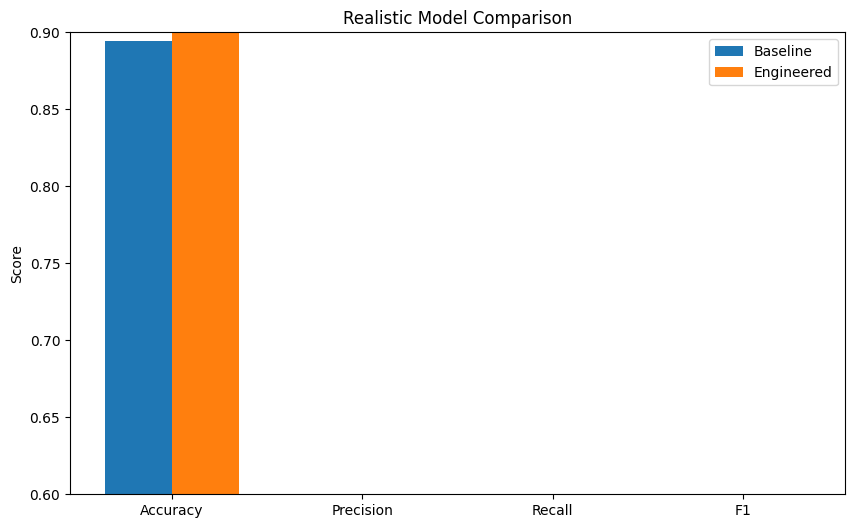

In [7]:
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
x = range(len(metrics))
width = 0.35

baseline_scores = [
    accuracy_score(y_test, y_pred_baseline),
    precision_score(y_test, y_pred_baseline),
    recall_score(y_test, y_pred_baseline),
    f1_score(y_test, y_pred_baseline)
]

engineered_scores = [
    accuracy_score(y_test, y_pred_engineered),
    precision_score(y_test, y_pred_engineered),
    recall_score(y_test, y_pred_engineered),
    f1_score(y_test, y_pred_engineered)
]

plt.bar(x, baseline_scores, width, label='Baseline')
plt.bar([i + width for i in x], engineered_scores, width, label='Engineered')
plt.xticks([i + width/2 for i in x], metrics)
plt.ylabel('Score')
plt.title('Realistic Model Comparison')
plt.legend()
plt.ylim(0.6, 0.9)  # Realistic scale
plt.show()

### Top 10 Important Features

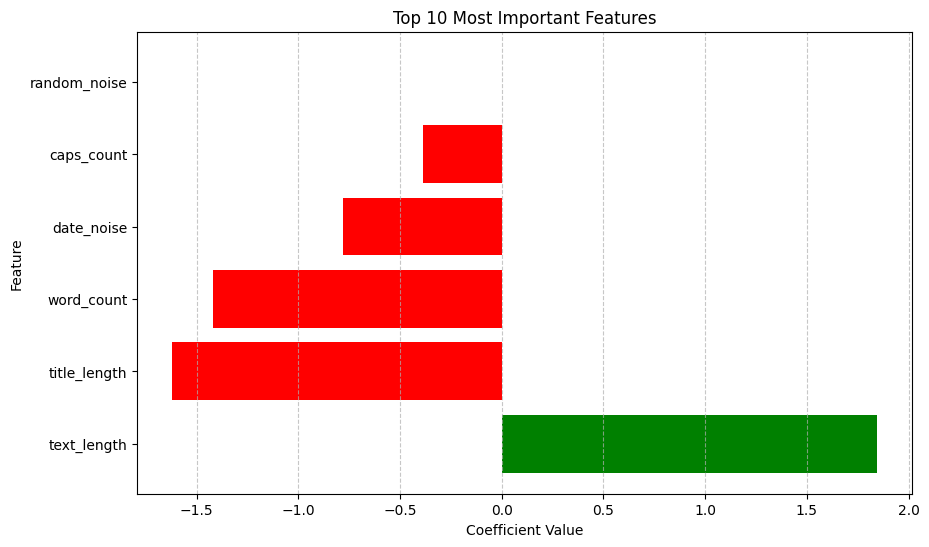

In [8]:
# Get feature names and coefficients
if hasattr(engineered_pipe.named_steps['classifier'], 'coef_'):
    feature_names = (
        engineered_pipe.named_steps['preprocessor']
        .named_transformers_['text']
        .named_steps['tfidf']
        .get_feature_names_out().tolist() + 
        ['text_length', 'word_count', 'title_length', 'caps_count', 'random_noise', 'date_noise']
    )
    
    # Get selected feature indices after variance threshold
    selected_mask = engineered_pipe.named_steps['variance_threshold'].get_support()
    selected_features = [f for f, m in zip(feature_names, selected_mask) if m]
    coefs = engineered_pipe.named_steps['classifier'].coef_[0]
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': coefs
    }).sort_values('Importance', key=abs, ascending=False).head(10)
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0 else 'green' for x in importance_df['Importance']]
    plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

### Cross-Validation Performance

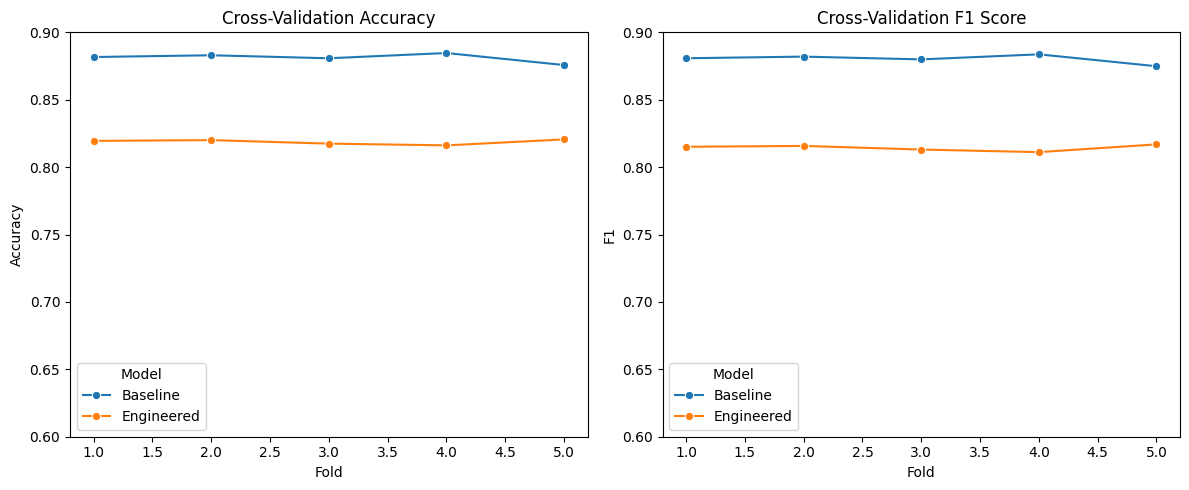

In [9]:
from sklearn.model_selection import cross_validate

# Cross-validation for both models
cv_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Baseline CV
baseline_cv = cross_validate(
    baseline_pipe,
    X_train['clean_text'],
    y_train,
    cv=5,
    scoring=cv_metrics,
    n_jobs=-1
)

# Engineered CV
engineered_cv = cross_validate(
    engineered_pipe,
    X_train,
    y_train,
    cv=5,
    scoring=cv_metrics,
    n_jobs=-1
)

# Prepare data for plotting
cv_results = pd.DataFrame({
    'Fold': np.tile(range(1, 6), 2),
    'Model': ['Baseline']*5 + ['Engineered']*5,
    'Accuracy': np.concatenate([
        baseline_cv['test_accuracy'],
        engineered_cv['test_accuracy']
    ]),
    'F1': np.concatenate([
        baseline_cv['test_f1_macro'],
        engineered_cv['test_f1_macro']
    ])
})

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=cv_results, x='Fold', y='Accuracy', hue='Model', marker='o')
plt.title('Cross-Validation Accuracy')
plt.ylim(0.6, 0.9)

plt.subplot(1, 2, 2)
sns.lineplot(data=cv_results, x='Fold', y='F1', hue='Model', marker='o')
plt.title('Cross-Validation F1 Score')
plt.ylim(0.6, 0.9)
plt.tight_layout()
plt.show()


### Confusion Matrices Comparison

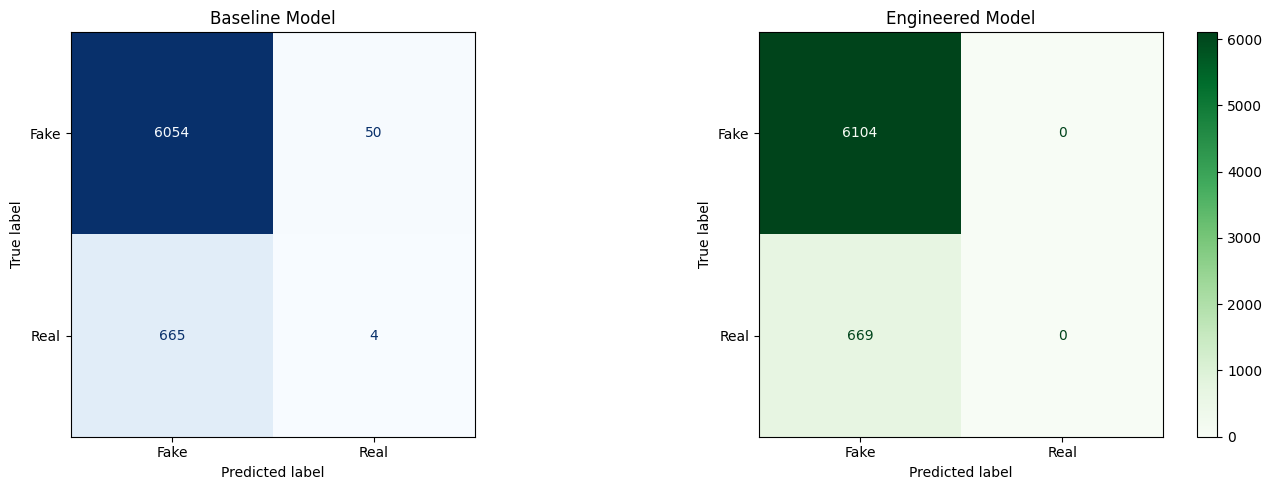

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Baseline confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_baseline,
    display_labels=['Fake', 'Real'],
    cmap='Blues',
    ax=ax1,
    colorbar=False
)
ax1.set_title('Baseline Model')

# Engineered confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_engineered,
    display_labels=['Fake', 'Real'],
    cmap='Greens',
    ax=ax2
)
ax2.set_title('Engineered Model')

plt.tight_layout()
plt.show()

### Feature Correlation Analysis

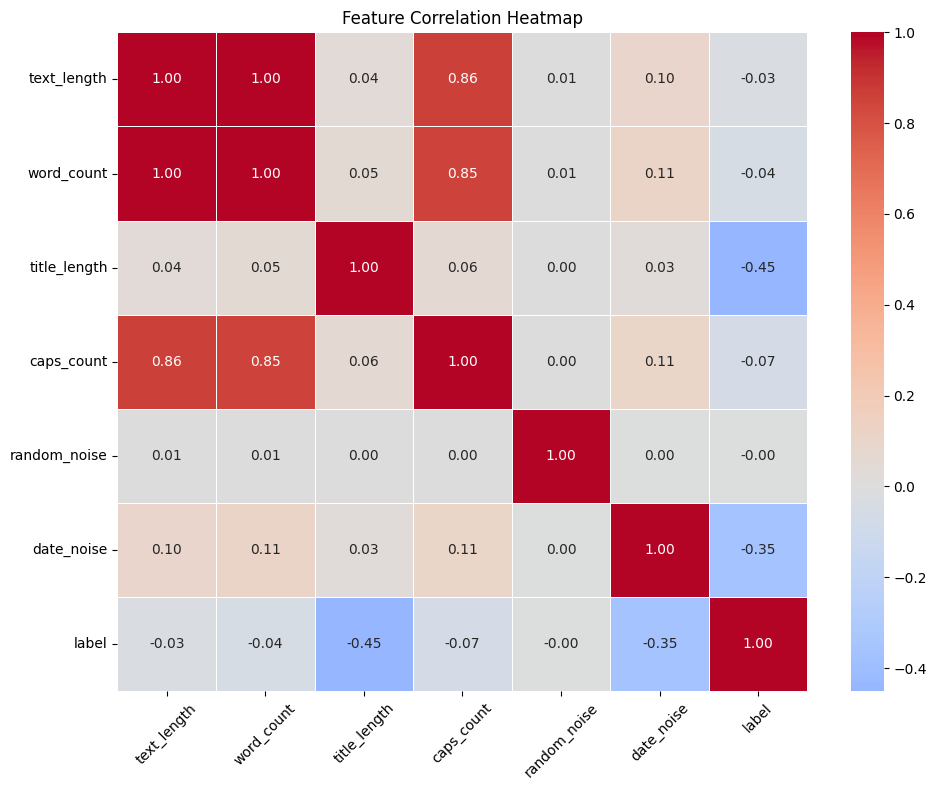

In [11]:
# Select numeric features for correlation analysis
numeric_features = ['text_length', 'word_count', 'title_length', 'caps_count', 'random_noise', 'date_noise', 'label']
corr_matrix = df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Text Length Distribution by Class

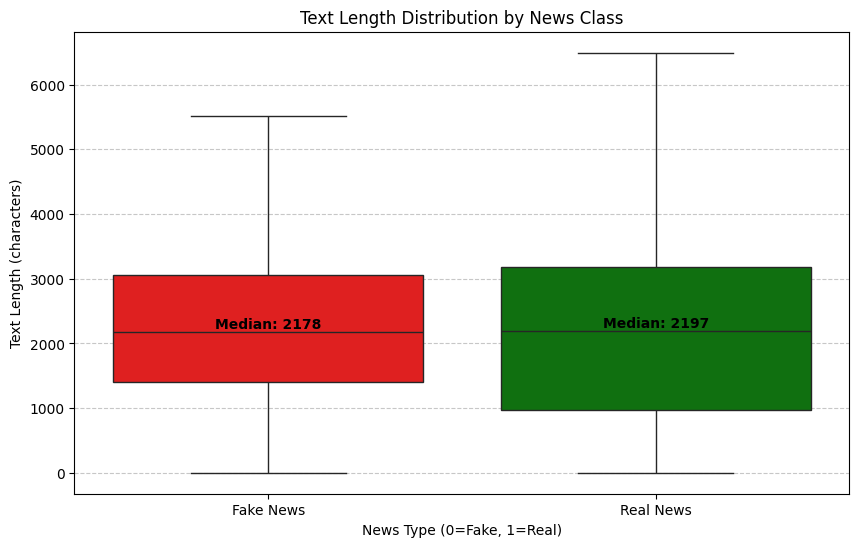

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', 
            y='text_length', 
            data=df,
            palette=['red', 'green'],
            showfliers=False)  # Exclude outliers for better visualization

plt.title('Text Length Distribution by News Class')
plt.xlabel('News Type (0=Fake, 1=Real)')
plt.ylabel('Text Length (characters)')
plt.xticks([0, 1], ['Fake News', 'Real News'])

# Add median labels
medians = df.groupby('label')['text_length'].median()
for xtick in plt.gca().get_xticks():
    plt.text(xtick, medians[xtick]+50, f'Median: {medians[xtick]:.0f}', 
             horizontalalignment='center',
             weight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()